In [27]:
'''
!pip install pandas
!pip install numpy
!pip install seaborn
!pip install matplotlib
!pip install scikit-learn
!pip install statsmodels
!pip install keras
!pip install mflow
!pip install tensorflow
!pip install mlflow
!pip install keras-tuner
!pip install keras
!pip install joblib
!pip install fastapi uvicorn
'''

'\n!pip install pandas\n!pip install numpy\n!pip install seaborn\n!pip install matplotlib\n!pip install scikit-learn\n!pip install statsmodels\n!pip install keras\n!pip install mflow\n!pip install tensorflow\n!pip install mlflow\n!pip install keras-tuner\n!pip install keras\n!pip install joblib\n!pip install fastapi uvicorn\n'

In [29]:
#!/usr/bin/env python3
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import tensorflow as tf
import joblib
import keras
import keras_tuner
import fastapi
import uvicorn
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout, BatchNormalization, Activation, Reshape
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from tensorflow.keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed, Reshape
from tensorflow.keras.layers import RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model
from re import X
from tensorflow.keras.models import load_model
import mlflow
from mlflow import keras as mlflow_keras
from fastapi import FastAPI
from pydantic import BaseModel



   

In [9]:
# Load the dataset
dataset_path = "../data/Tetuan City power consumption.csv"
data = pd.read_csv(dataset_path, parse_dates=["DateTime"], index_col=["DateTime"])
data.head()

,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
DateTime,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


In [10]:
# Data Preprocessing
# Step 1: Resample to hourly frequency
timesteps_per_day = 24

zones = ['Zone 1', 'Zone 2', 'Zone 3']

best_r2_score = float('-inf')
window_size = 10
best_model = None
best_loss = float('inf') 
result = []

data_hr = data.copy()
data_hr_sorted = data_hr.sort_index()
column_group = ['Zone 1 Power Consumption', 'Zone 2  Power Consumption', 'Zone 3  Power Consumption']
target = data_hr_sorted[column_group].resample('h').mean()
target[column_group] = target[column_group].ffill().bfill()

# Step 2: Interpolate 
for col in ['general diffuse flows', 'Zone 3  Power Consumption', 'diffuse flows']:
  rolling_mean = data[col].rolling(window=window_size).mean()
  rolling_std = data[col].rolling(window=window_size).std()
  outliers = (data[col] - rolling_mean).abs() > 3 * rolling_std
  data.loc[outliers, col] = None

data[['general diffuse flows', 'Zone 3  Power Consumption', 'diffuse flows']] = \
data[['general diffuse flows', 'Zone 3  Power Consumption', 'diffuse flows']].interpolate(method='linear')

# Step: 3 Scale
X = []
y = []

for i in range(window_size, len(data_hr_sorted) - 6, 6):  # step by 6 (1 hour)
  X.append(data_hr_sorted.iloc[i - window_size: i].values)
  y.append(target.iloc[i // 6].values)

X = np.array(X)
y = np.array(y)

x_scaler = MinMaxScaler()
X_scaled = x_scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y)
y_scaled = y_scaled.reshape(y_scaled.shape[0], 1, y_scaled.shape[1])



#Step 5: Split Index
split_index = int(0.8 * len(X_scaled))
X_train_scaled = X_scaled[:split_index]
X_test_scaled = X_scaled[split_index:]
y_train_scaled = y_scaled[:split_index]
y_test_scaled = y_scaled[split_index:]

# Get shapes
n_timesteps = X_train_scaled.shape[1]
n_features = X_train_scaled.shape[2]
n_output_features = y_train_scaled.shape[2]

In [11]:
# Step 6: Define the model
model = Sequential()
model.add(LSTM(256, input_shape=(n_timesteps, n_features), return_sequences=False, activation='relu'))
model.add(RepeatVector(y_train_scaled.shape[1]))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(Dropout(0.1))
model.add(TimeDistributed(Dense(n_output_features, activation='linear')))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-9)
model_checkpoint = ModelCheckpoint(f'best_model_window_{window_size}.h5', monitor='val_loss', save_best_only=True)


c:\Users\Lenovo\Documents\Projects_sds\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
#Step 7: Model Fit
history = model.fit(
      X_train_scaled, y_train_scaled,
      epochs=100,
      batch_size=16,
      validation_split=0.2,
      callbacks=[early_stop, reduce_lr, model_checkpoint]
      )

Epoch 1/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7124 - loss: 0.0355

350/350 ━━━━━━━━━━━━━━━━━━━━ 13s 23ms/step - accuracy: 0.7620 - loss: 0.0125 - val_accuracy: 0.9320 - val_loss: 0.0064 - learning_rate: 0.0010
Epoch 2/100
348/350 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8230 - loss: 0.0030

350/350 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.8315 - loss: 0.0027 - val_accuracy: 0.9342 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 3/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8677 - loss: 0.0015

350/350 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.8773 - loss: 0.0013 - val_accuracy: 0.9499 - val_loss: 9.9997e-04 - learning_rate: 0.0010
Epoch 4/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.9005 - loss: 0.0011 - val_accuracy: 0.9557 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 5/100
348/350 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9123 - loss: 8.9319e-04

350/350 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.9068 - loss: 8.7952e-04 - val_accuracy: 0.9442 - val_loss: 8.4332e-04 - learning_rate: 0.0010
Epoch 6/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9048 - loss: 7.9054e-04

350/350 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.9077 - loss: 8.0741e-04 - val_accuracy: 0.8999 - val_loss: 8.0753e-04 - learning_rate: 0.0010
Epoch 7/100
348/350 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9086 - loss: 7.4336e-04

350/350 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.9123 - loss: 7.1475e-04 - val_accuracy: 0.9471 - val_loss: 5.6773e-04 - learning_rate: 0.0010
Epoch 8/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9051 - loss: 6.5762e-04

350/350 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - accuracy: 0.9121 - loss: 6.1728e-04 - val_accuracy: 0.9464 - val_loss: 5.3134e-04 - learning_rate: 0.0010
Epoch 9/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9215 - loss: 5.5463e-04

350/350 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.9229 - loss: 5.9195e-04 - val_accuracy: 0.9549 - val_loss: 3.4719e-04 - learning_rate: 0.0010
Epoch 10/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.9232 - loss: 5.5938e-04 - val_accuracy: 0.9664 - val_loss: 3.8666e-04 - learning_rate: 0.0010
Epoch 11/100
349/350 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9227 - loss: 5.5483e-04

350/350 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.9283 - loss: 5.3959e-04 - val_accuracy: 0.9735 - val_loss: 3.0229e-04 - learning_rate: 0.0010
Epoch 12/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.9277 - loss: 5.1746e-04 - val_accuracy: 0.9778 - val_loss: 3.4013e-04 - learning_rate: 0.0010
Epoch 13/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.9284 - loss: 4.4778e-04 - val_accuracy: 0.9449 - val_loss: 5.9236e-04 - learning_rate: 0.0010
Epoch 14/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.9290 - loss: 4.1788e-04 - val_accuracy: 0.9678 - val_loss: 3.6277e-04 - learning_rate: 0.0010
Epoch 15/100
349/350 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9392 - loss: 3.5351e-04

350/350 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.9397 - loss: 3.5568e-04 - val_accuracy: 0.9778 - val_loss: 2.2937e-04 - learning_rate: 5.0000e-04
Epoch 16/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.9433 - loss: 3.5135e-04 - val_accuracy: 0.9828 - val_loss: 2.7675e-04 - learning_rate: 5.0000e-04
Epoch 17/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.9427 - loss: 3.2531e-04 - val_accuracy: 0.9785 - val_loss: 2.8822e-04 - learning_rate: 5.0000e-04
Epoch 18/100
348/350 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9419 - loss: 3.0281e-04

350/350 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.9431 - loss: 3.1642e-04 - val_accuracy: 0.9793 - val_loss: 2.1284e-04 - learning_rate: 5.0000e-04
Epoch 19/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 11s 29ms/step - accuracy: 0.9440 - loss: 3.1502e-04 - val_accuracy: 0.9714 - val_loss: 2.2798e-04 - learning_rate: 5.0000e-04
Epoch 20/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9373 - loss: 3.0989e-04

350/350 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.9449 - loss: 3.0954e-04 - val_accuracy: 0.9771 - val_loss: 1.5637e-04 - learning_rate: 5.0000e-04
Epoch 21/100
348/350 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9496 - loss: 2.7928e-04

350/350 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.9474 - loss: 2.7445e-04 - val_accuracy: 0.9871 - val_loss: 1.1218e-04 - learning_rate: 2.5000e-04
Epoch 22/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step - accuracy: 0.9469 - loss: 2.7258e-04 - val_accuracy: 0.9821 - val_loss: 1.5637e-04 - learning_rate: 2.5000e-04
Epoch 23/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - accuracy: 0.9476 - loss: 2.8672e-04 - val_accuracy: 0.9771 - val_loss: 1.6733e-04 - learning_rate: 2.5000e-04
Epoch 24/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.9460 - loss: 2.6568e-04 - val_accuracy: 0.9814 - val_loss: 1.3538e-04 - learning_rate: 2.5000e-04
Epoch 25/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.9488 - loss: 2.6708e-04 - val_accuracy: 0.9857 - val_loss: 1.2637e-04 - learning_rate: 2.5000e-04
Epoch 26/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.9517 - loss: 2.7377e-04 - val_accuracy: 0.9785 - val_loss: 1.4287e-04 - learning_rate: 2.5000e-04
Epoch

350/350 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.9461 - loss: 2.5373e-04 - val_accuracy: 0.9828 - val_loss: 1.1151e-04 - learning_rate: 1.2500e-04
Epoch 28/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.9481 - loss: 2.4667e-04 - val_accuracy: 0.9800 - val_loss: 1.3426e-04 - learning_rate: 1.2500e-04
Epoch 29/100
349/350 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9452 - loss: 2.4385e-04

350/350 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.9467 - loss: 2.4689e-04 - val_accuracy: 0.9828 - val_loss: 7.1982e-05 - learning_rate: 1.2500e-04
Epoch 30/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.9452 - loss: 2.5503e-04 - val_accuracy: 0.9800 - val_loss: 1.1419e-04 - learning_rate: 1.2500e-04
Epoch 31/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.9465 - loss: 2.6093e-04 - val_accuracy: 0.9843 - val_loss: 1.1450e-04 - learning_rate: 1.2500e-04
Epoch 32/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.9533 - loss: 2.4349e-04 - val_accuracy: 0.9886 - val_loss: 8.4437e-05 - learning_rate: 6.2500e-05
Epoch 33/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.9528 - loss: 2.2655e-04 - val_accuracy: 0.9850 - val_loss: 8.0553e-05 - learning_rate: 6.2500e-05
Epoch 34/100
350/350 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - accuracy: 0.9508 - loss: 2.3951e-04 - val_accuracy: 0.9907 - val_loss: 8.0256e-05 - learning_rate: 6.2500e-05
Epoch 3

55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
  New best model found!

Zone 1 - TOTAL: RMSE: 483.99, MAE: 400.75, R²: 0.99
Best Window Size for Zone 1 : 10, & R2-Score :0.9939759962924017


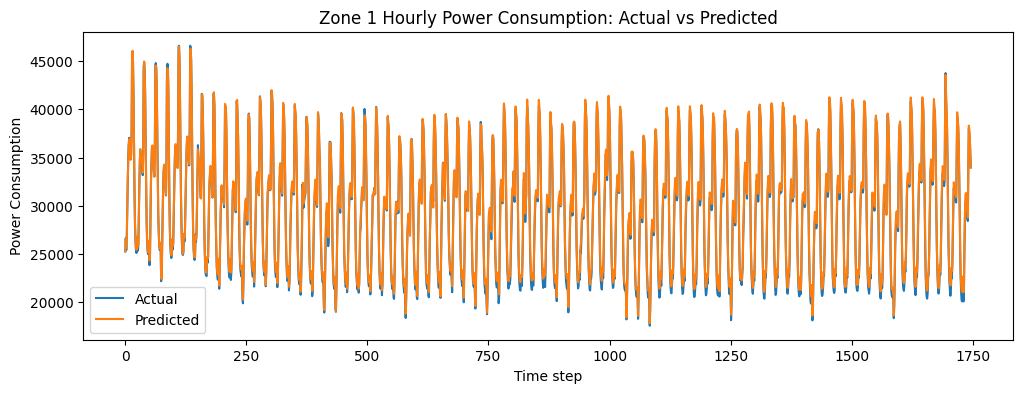


Zone 2 - TOTAL: RMSE: 377.52, MAE: 292.73, R²: 1.00
Best Window Size for Zone 2 : 10, & R2-Score :0.9955989698468539


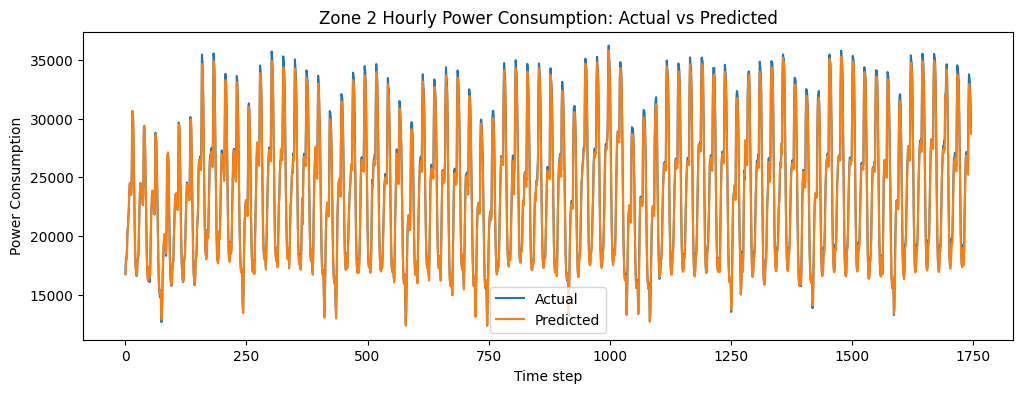


Zone 3 - TOTAL: RMSE: 469.87, MAE: 383.48, R²: 0.98


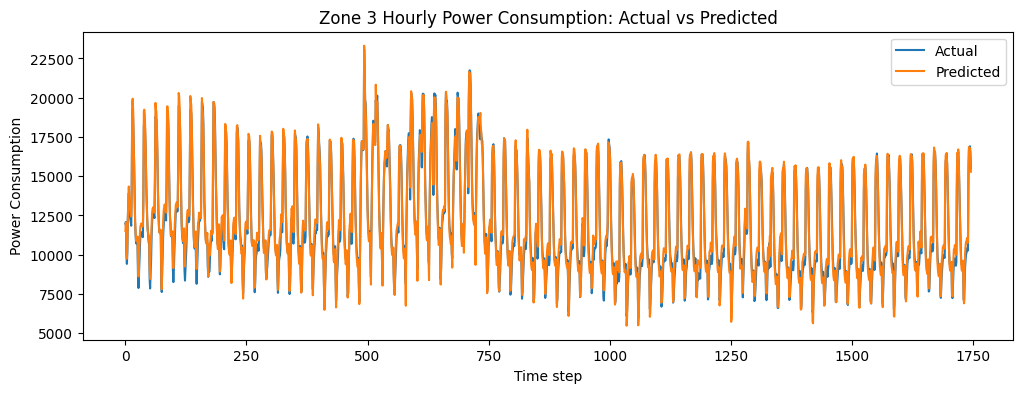

Best model saved successfully to best_power_consumption_model.h5
Scalers saved successfully to x_scaler.pkl and y_scaler.pkl


In [13]:




# Step 8: Evaluate the model
# Predict
y_pred = model.predict(X_test_scaled)

# Inverse transform predictions. Pad zeros for the non-target features:
pad_cols = n_features - n_output_features
zeros_for_pred = np.zeros((y_pred.reshape(-1, n_output_features).shape[0], pad_cols))
pred_full  = np.concatenate([zeros_for_pred, y_pred.reshape(-1, n_output_features)], axis=1)

inv_pred = x_scaler.inverse_transform(pred_full)[:, -n_output_features:]
inv_pred = inv_pred.reshape(y_pred.shape)

zeros_for_true = np.zeros((y_test_scaled.reshape(-1, n_output_features).shape[0], pad_cols))
true_full = np.concatenate( [zeros_for_true, y_test_scaled.reshape(-1, n_output_features)], axis=1)
inv_true = x_scaler.inverse_transform(true_full)[:, -n_output_features:]
inv_true = inv_true.reshape(y_test_scaled.shape)


# Print Total and Daily Scores for Each Zone
best_loss = float('inf')


# Evaluate on the validation set
val_loss = history.history['val_loss'][-1]


# Check if current model is the best
if val_loss < best_loss:
  best_loss = val_loss
  #best_params = params
  best_model = model # Store the model object
  print("  New best model found!")


for i, zone in enumerate(zones):
  y_true = inv_true[:, 0, i]  # flatten to 1D
  y_pred = inv_pred[:, 0, i]  # flatten to 1D

  # Total metrics
  rmse_total = np.sqrt(mean_squared_error(y_true, y_pred))
  mae_total = mean_absolute_error(y_true, y_pred)
  r2_total = r2_score(y_true, y_pred)
  print(f'\n{zone} - TOTAL: RMSE: {rmse_total:.2f}, MAE: {mae_total:.2f}, R²: {r2_total:.2f}')

  result.append((window_size, rmse_total, mae_total, r2_total))

  if r2_total > best_r2_score:
    best_r2_score = r2_total
    best_window_size = window_size
    print(f'Best Window Size for {zone} : {window_size}, & R2-Score :{best_r2_score}')

  # Daily metrics
  num_days = len(y_true) // timesteps_per_day

  #Mean of Daily Scores
  daily_rmse = []
  daily_mae = []
  daily_r2 = []
  for day in range(num_days):
    start = day * timesteps_per_day
    end = start + timesteps_per_day
    daily_rmse.append(np.sqrt(mean_squared_error(y_true[start:end], y_pred[start:end])))
    daily_mae.append(mean_absolute_error(y_true[start:end], y_pred[start:end]))
    daily_r2.append(r2_score(y_true[start:end], y_pred[start:end]))
  


  # Plot actual vs predicted
  plt.figure(figsize=(12, 4))
  plt.plot(y_true, label='Actual')
  plt.plot(y_pred, label='Predicted')
  plt.title(f'{zone} Hourly Power Consumption: Actual vs Predicted')
  plt.xlabel('Time step')
  plt.ylabel('Power Consumption')
  plt.legend()
  plt.show()

pd.DataFrame(result, columns=["Window_Size", "RMSE", "MAE", "R2_Score"]), best_model, x_scaler, X_test_scaled 


# Define the desired path in Google Drive
drive_save_path = 'best_power_consumption_model.h5'

# Save the best_model object to the specified Google Drive path
if best_model:
    best_model.save(drive_save_path)
    print(f"Best model saved successfully to {drive_save_path}")

    # Save the x_scaler and y_scaler objects
    import joblib
    joblib.dump(x_scaler, 'x_scaler.pkl')
    joblib.dump(y_scaler, 'y_scaler.pkl')
    print(f"Scalers saved successfully to x_scaler.pkl and y_scaler.pkl")

else:
    print("No best model was found to save.")

In [14]:
best_window_size

10

In [15]:
# Load the best model
best_model = load_model('best_power_consumption_model.h5', custom_objects={'mse': tf.keras.losses.MeanSquaredError()})
best_model

<Sequential name=sequential, built=True>

In [16]:
pred_next_hr = best_model.predict(X_test_scaled[-1:])
pred_next_hr_flat = pred_next_hr.reshape(-1, 3)

# Inverse transform predictions. Pad zeros for the non-target features:
n_output_features = y_scaler.data_min_.shape[0]
pad_cols = X_test_scaled.shape[2] - n_output_features 
zeros_for_pred = np.zeros((pred_next_hr_flat.shape[0], pad_cols))

# Concatenate zeros and predictions in the order they were in the original data
pred_full  = np.concatenate([zeros_for_pred, pred_next_hr_flat], axis=1)

# Use x_scaler to inverse transform the full padded array
inv_pred = x_scaler.inverse_transform(pred_full)[:, -n_output_features:]

#print the timestamp (datae and time) for pred_next_hr
last_timestamp = data.index[-1]
print("Last Timestamp:")
print(last_timestamp)
print()
print("Next Hour Forecast for Zone 1, Zone 2, and Zone 3:")

# Store inv_pred in a dataframe dict with zones name
pred_next_hr_inv = pd.DataFrame(inv_pred, columns=['Zone 1', 'Zone 2', 'Zone 3'])
print(pred_next_hr_inv)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step
Last Timestamp:
2017-12-30 23:50:00

Next Hour Forecast for Zone 1, Zone 2, and Zone 3:
         Zone 1        Zone 2      Zone 3
0  33946.522065  28711.620331  15285.2738


In [17]:
def multi_step_forecast3(model, last_sequence, x_scaler, n_steps, n_features, n_output_features):
    predictions = []
    current_input = last_sequence.copy()

    pad_cols = n_features - n_output_features

    for _ in range(n_steps):
        # Predict next step 
        y_pred_scaled = model.predict(current_input)

        # Inverse transform for storing and displaying
        zeros_for_pred_inv = np.zeros((1, pad_cols))
        pred_full_inv = np.concatenate([zeros_for_pred_inv, y_pred_scaled.reshape(1, n_output_features)], axis=1)
        inv_pred = x_scaler.inverse_transform(pred_full_inv)[:, -n_output_features:]
        predictions.append(inv_pred.flatten())

        # Prepare the scaled prediction to be appended to the input sequence
        zeros_for_pred_scaled = np.zeros((1, 1, pad_cols))
        padded_pred_scaled = np.concatenate([zeros_for_pred_scaled, y_pred_scaled], axis=2)

        # Update input sequence by removing oldest timestep and appending new scaled prediction
        current_input = np.concatenate([current_input[:, 1:, :], padded_pred_scaled], axis=1)

    return np.array(predictions)

In [18]:
def walk_forward_forecast(model, X_test_scaled, scaler, input_days=10, output_days=1, target_columns=['Zone 1 Power Consumption', 'Zone 2  Power Consumption','Zone 3  Power Consumption']):
    """
    Walk-forward validation: for each timestep in the test set, use the previous input_days timesteps as input,
    predict the next output_days, store predictions, and print total and daily scores for each zone.
    """
   


    predictions = []
    actuals = []
    n_samples = X_test_scaled.shape[0]
    n_features = X_test_scaled.shape[2]
    n_targets = len(target_columns)

    # Assuming y_test_scaled corresponds to X_test_scaled and is globally available
    if 'y_test_scaled' not in globals() or y_test_scaled.shape[0] != n_samples or y_test_scaled.shape[2] != n_targets:
         print("y_test_scaled is not available or does not match the expected shape for evaluation.")
         return None, None

    pad_cols = n_features - n_targets
    if pad_cols < 0:
        print("Error: Number of features in input is less than number of target features.")
        return None, None

    # Initialize the history with the first input_days from the test set
    history = [X_test_scaled[0, i, :] for i in range(input_days)]


    for i in range(n_samples):
        # The input for prediction is the current history window
        X_input = np.array(history).reshape(1, input_days, n_features)


        # Predict the next output_days (model is assumed to output scaled values)
        y_pred_scaled = model.predict(X_input, verbose=0)  

        # Inverse transform predictions.
        inv_pred_steps = []
        for step in range(output_days):
            
            # Extract prediction for the current output timestep
            y_pred_step_scaled = y_pred_scaled[:, step, :] 
            y_pred_step_flat = y_pred_step_scaled.reshape(-1, n_targets) 


            zeros_for_pred_inv = np.zeros((y_pred_step_flat.shape[0], pad_cols))
            
            # Concatenate zeros and predictions. Assuming targets are the last columns.
            pred_full_inv_scaled = np.concatenate([zeros_for_pred_inv, y_pred_step_flat], axis=1)

            # Inverse transform using the x_scaler
            inv_pred_step = scaler.inverse_transform(pred_full_inv_scaled)[:, -n_targets:] #

            inv_pred_steps.append(inv_pred_step.flatten()) 


        predictions.append(np.array(inv_pred_steps).flatten()) 

        # Get actual values from y_test_scaled for the corresponding output_days
        actual_scaled_step = y_test_scaled[i, 0, :].reshape(-1, n_targets) # Shape (1, n_targets)


        # Update history for the next prediction step
        # Remove the oldest timestep from history
        history.pop(0)
        
        
        # Append the actual observed values for the predicted timestep(s) to the history
        actual_scaled_padded = np.zeros((1, n_features))
        actual_scaled_padded[:, -n_targets:] = actual_scaled_step # Place actual scaled target values in the correct columns
        history.append(actual_scaled_padded.flatten()) # Append the padded actual scaled values to history


    # Stack predictions and actuals
    if not predictions or not actuals:
        print("No predictions or actuals were collected. Check data processing and loop.")
        return None, None

    predictions = np.array(predictions)
    actuals = np.array(actuals)

    # Ensure actuals and predictions have the same shape before calculating metrics
    if predictions.shape != actuals.shape:
        print(f"Error: Shape mismatch between predictions ({predictions.shape}) and actuals ({actuals.shape}). Cannot calculate metrics.")
        return predictions, actuals 


    # Reshape for metric calculation: (n_samples * output_days, n_targets)
    predictions_reshaped = predictions.reshape(-1, n_targets)
    actuals_reshaped = actuals.reshape(-1, n_targets)


    # Print total and daily scores for each zone
    timesteps_per_score = output_days

    for idx, zone in enumerate(['Zone 1', 'Zone 2', 'Zone 3']):
        # Ensure there are enough data points for evaluation for this zone
        if actuals_reshaped.shape[0] == 0:
             print(f"No actual data available for {zone} evaluation.")
             continue

        rmse = np.sqrt(mean_squared_error(actuals_reshaped[:, idx], predictions_reshaped[:, idx]))
        mae = mean_absolute_error(actuals_reshaped[:, idx], predictions_reshaped[:, idx])
        r2 = r2_score(actuals_reshaped[:, idx], predictions_reshaped[:, idx])
        print(f'\n{zone} - Total RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}')

        # Daily scores (or scores per output_days)
        if output_days == 1 and timesteps_per_day is not None and actuals_reshaped.shape[0] >= timesteps_per_day:
            print(f'{zone} - Mean Daily Scores (approx):')
            
            # Calculate daily metrics on the reshaped arrays
            num_days = actuals_reshaped.shape[0] // timesteps_per_day
            daily_rmse = []
            daily_mae = []
            daily_r2 = []
            for day in range(num_days):
                start = day * timesteps_per_day
                end = start + timesteps_per_day
                if end <= actuals_reshaped.shape[0]:
                    daily_rmse.append(np.sqrt(mean_squared_error(actuals_reshaped[start:end, idx], predictions_reshaped[start:end, idx])))
                    daily_mae.append(mean_absolute_error(actuals_reshaped[start:end, idx], predictions_reshaped[start:end, idx]))
                    daily_r2.append(r2_score(actuals_reshaped[start:end, idx], predictions_reshaped[start:end, idx]))
            if daily_rmse: 
                 print(f'  Mean Daily RMSE: {np.mean(daily_rmse):.2f}, MAE: {np.mean(daily_mae):.2f}, R²: {np.mean(daily_r2):.2f}')
            else:
                 print("  Not enough data for daily score calculation.")


        # Plot
        plt.figure(figsize=(12, 4))
        # Plot using the reshaped arrays for continuous plotting
        plt.plot(actuals_reshaped[:, idx], label='Actual')
        plt.plot(predictions_reshaped[:, idx], label='Predicted')
        plt.title(f'{zone} Power Consumption: Actual vs Predicted (Walk-forward)')
        plt.xlabel(f'Time step (each step represents 1 original time step)') # Corrected label
        plt.ylabel('Power Consumption')
        plt.legend()
        plt.show()

    return predictions, actuals

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
         Zone 1        Zone 2        Zone 3
0  33946.522065  28711.620331  15285.273800
1  34486.067922  28685.248033  15942.251558
2  34950.278343  28713.451621  16395.588598
3  35363.827491  28744.719395  16740.097978
4  35759.577720  28780.803548  17023.333985
5  36141.102515  28823.949775  17274.127933


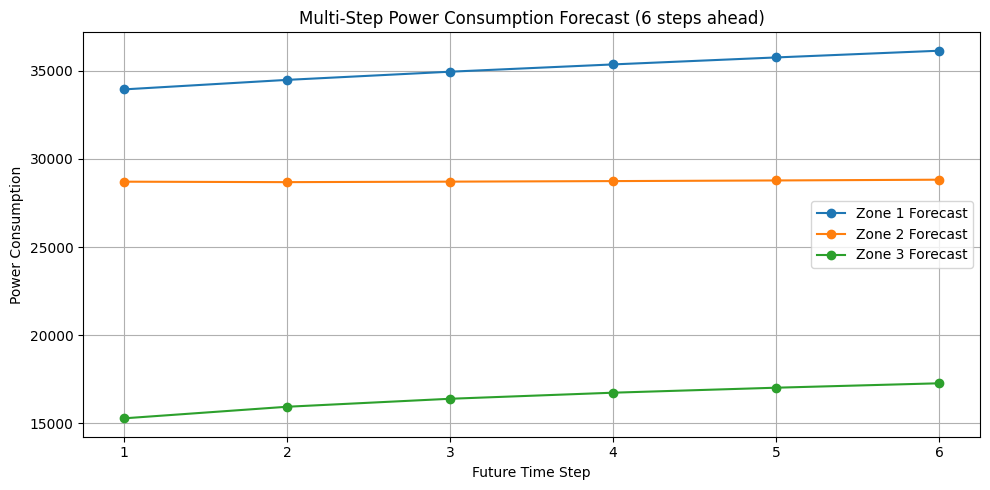

In [21]:
# Plot Multi-Step Forecast
n_steps = 6

# Ensure X_test_scaled and best_model, x_scaler are available
if 'X_test_scaled' in globals() and X_test_scaled is not None and \
   'best_model' in globals() and best_model is not None and \
   'x_scaler' in globals() and x_scaler is not None and \
   'n_features' in globals() and n_features is not None and \
   'n_output_features' in globals() and n_output_features is not None:

    # Get the last sequence from the test set as the input for multi-step forecasting
    last_sequence = X_test_scaled[-1:] 

    # Generate multi-step forecast
    multi_step_predictions = multi_step_forecast3(
        best_model,
        last_sequence,
        x_scaler,
        n_steps,
        n_features,
        n_output_features
    )

    # store prediction in pandaframe dict with zone name and timesteps in which the prediction happen
    multi_step_predictions_df = pd.DataFrame(multi_step_predictions, columns=['Zone 1', 'Zone 2', 'Zone 3'])
    print(multi_step_predictions_df)

    # Plot the multi-step forecast
    plt.figure(figsize=(10, 5))
    for i, zone in enumerate(zones):
        # multi_step_predictions shape is (n_steps, n_targets)
        plt.plot(range(1, n_steps + 1), multi_step_predictions[:, i], marker='o', linestyle='-', label=f'{zone} Forecast') # Added marker and linestyle

    plt.title(f'Multi-Step Power Consumption Forecast ({n_steps} steps ahead)')
    plt.xlabel('Future Time Step')
    plt.ylabel('Power Consumption')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Required variables (X_test_scaled, best_model, x_scaler, n_features, n_output_features) are not available to generate multi-step forecast.")